In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [129]:
image_path = '/kaggle/input/flickr30k/flickr30k_images/'

In [130]:
data = pd.read_csv("/kaggle/input/flickr30k/captions.txt")
data.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,Two young White males are outside near many b...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [131]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/kaggle/input/flickr30k/flickr30k_images/{temp_df.image_name[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.comment[i], 20)))
        plt.axis("off")

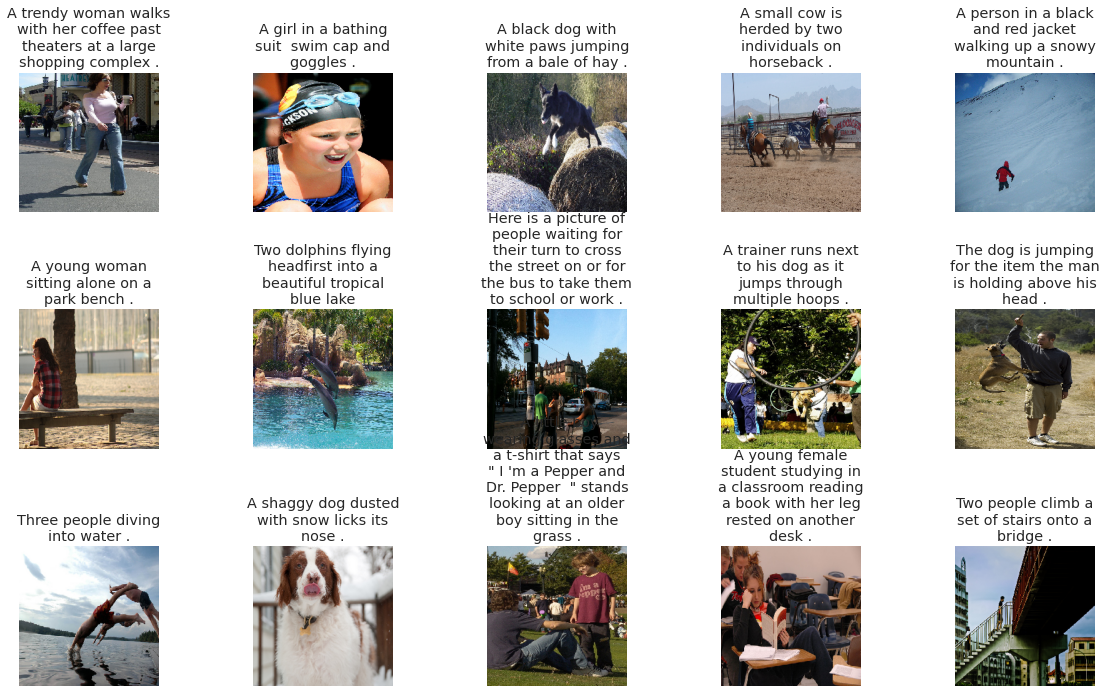

In [132]:
display_images(data.sample(15))

In [133]:
def text_preprocessing(data):
    data['comment'] = data['comment'].apply(lambda x: x.lower())
    data['comment'] = data['comment'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['comment'] = data['comment'].apply(lambda x: x.replace("\s+"," "))
    data['comment'] = data['comment'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['comment'] = "startseq "+data['comment']+" endseq"
    return data

In [134]:
data = text_preprocessing(data)
captions = data['comment'].tolist()
captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [184]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image_name'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image_name'].isin(train_images)]
test = data[data['image_name'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 12, 21, 20, 708, 13, 54, 79, 194, 1421, 2]

In [136]:
train.shape

(135080, 3)

In [137]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
img_size = 224
features = {}
for image in tqdm(data['image_name'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 31783/31783 [44:59<00:00, 11.77it/s]  


In [147]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [148]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [149]:
from tensorflow.keras.utils import plot_model

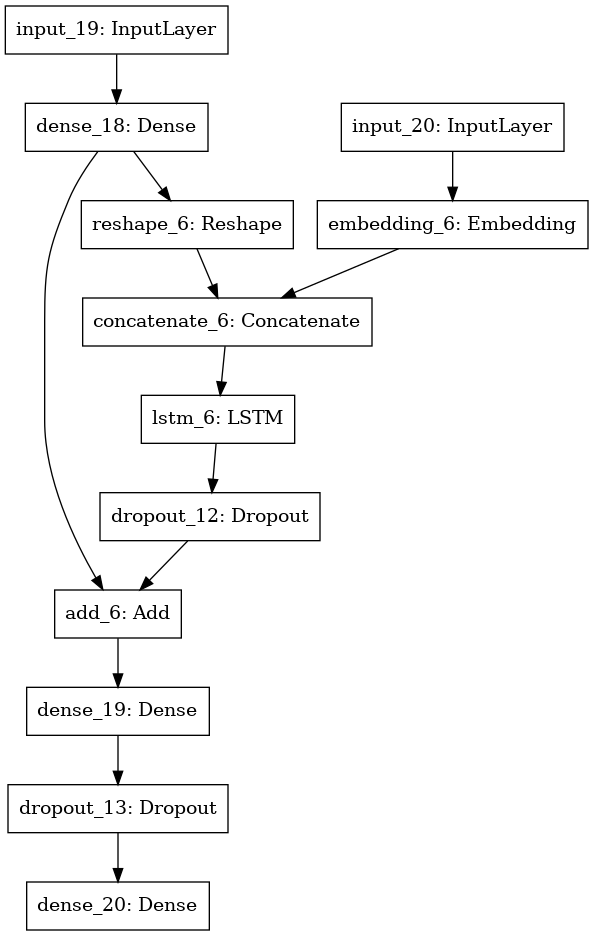

In [150]:
plot_model(caption_model)

In [151]:
caption_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1920)]       0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 256)          491776      input_19[0][0]                   
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 74)]         0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 1, 256)       0           dense_18[0][0]                   
___________________________________________________________________________________________

In [152]:
test.shape

(23835, 3)

In [153]:
train_generator = CustomDataGenerator(df=train,X_col='image_name',y_col='comment',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image_name',y_col='comment',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [154]:
test

,image_name,comment_number,comment
0,544301311.jpg,0,startseq two women with white head garb and lo...
1,544301311.jpg,1,startseq two women in traditional european dre...
2,544301311.jpg,2,startseq the women sit outside on the steps re...
3,544301311.jpg,3,startseq two women in period dress sitting in ...
4,544301311.jpg,4,startseq two girls sit by doorway on the steps...
...,...,...,...
23830,998845445.jpg,0,startseq man in shorts and hawaiian shirt lean...
23831,998845445.jpg,1,startseq young man hanging over the side of bo...
23832,998845445.jpg,2,startseq man is leaning off of the side of blu...
23833,998845445.jpg,3,startseq man riding small boat in harbor with ...


In [155]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [157]:
history = caption_model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/5
2110/2110 [==============================] - 380s 180ms/step - loss: 3.8086 - val_loss: 4.0645

Epoch 00001: val_loss improved from 4.09365 to 4.06447, saving model to model.pkl
Epoch 2/5
2110/2110 [==============================] - 375s 178ms/step - loss: 3.7671 - val_loss: 4.0704

Epoch 00002: val_loss did not improve from 4.06447
Epoch 3/5
2110/2110 [==============================] - 374s 177ms/step - loss: 3.7352 - val_loss: 4.0690

Epoch 00003: val_loss did not improve from 4.06447
Epoch 4/5
2110/2110 [==============================] - 345s 164ms/step - loss: 3.7089 - val_loss: 4.0717

Epoch 00004: val_loss did not improve from 4.06447

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/5
2110/2110 [==============================] - 379s 180ms/step - loss: 3.6266 - val_loss: 4.0493

Epoch 00005: val_loss improved from 4.06447 to 4.04928, saving model to model.pkl


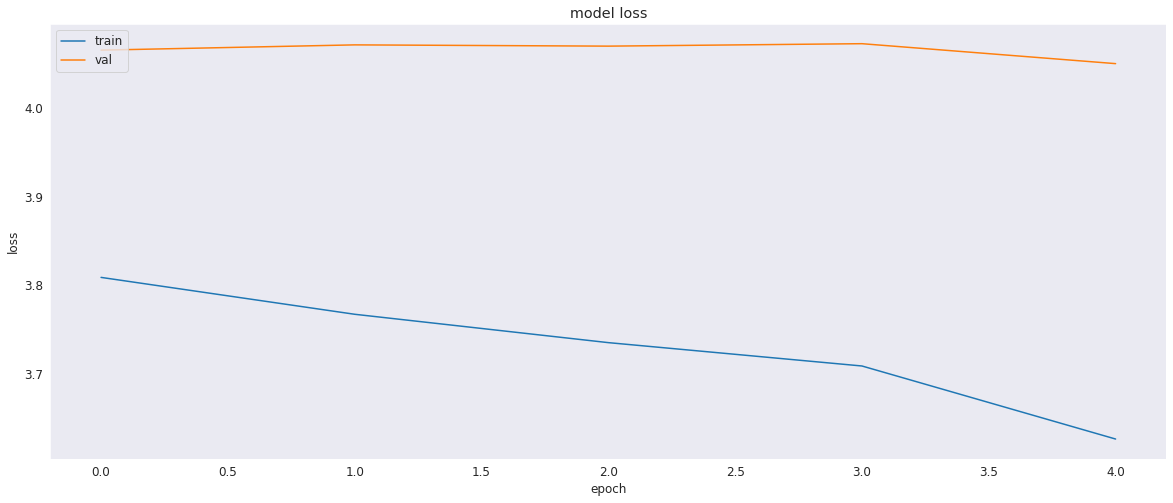

In [158]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [160]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [161]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [162]:
test.shape

(23835, 3)

In [195]:
samples = test.sample(10)
samples.reset_index(drop=True,inplace=True)

In [196]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image_name']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image_name'], tokenizer, max_length, features)
    samples.loc[index,'comment'] = caption

KeyError: 10

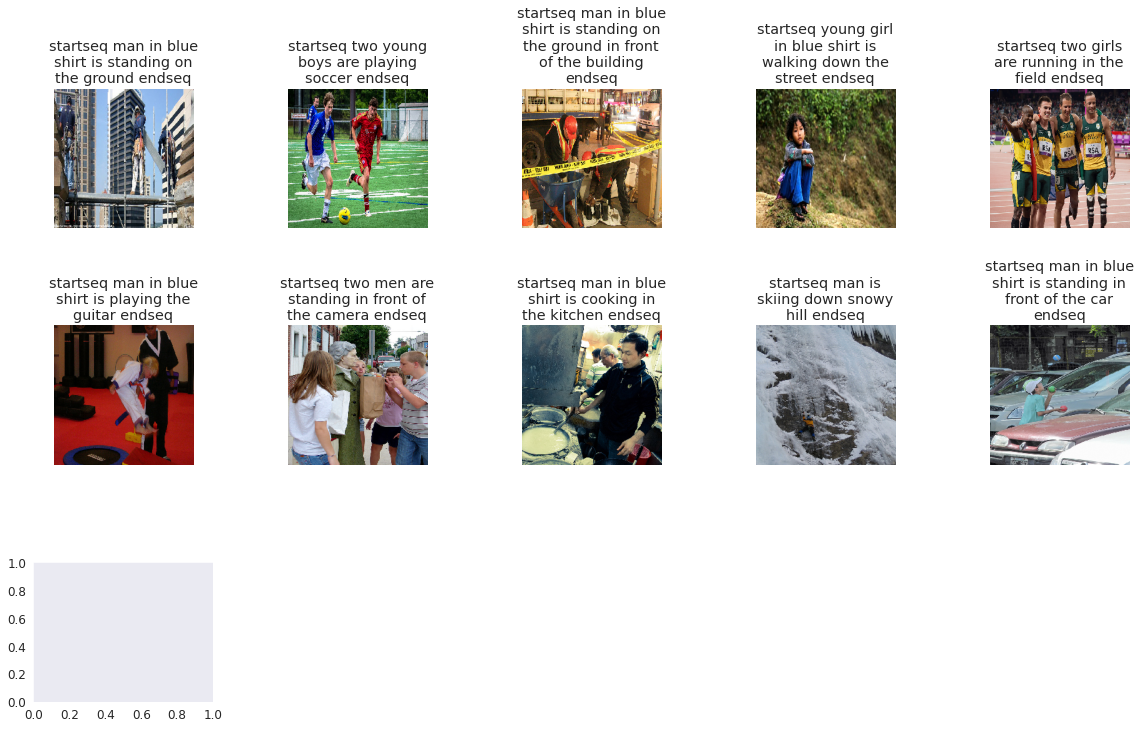

In [197]:
display_images(samples)

In [198]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [199]:
import pickle

# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [200]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Example usage
word = idx_to_word(102, tokenizer)  # Replace 5 with your integer
print(word)

dogs


record['image']

In [201]:
with open('features.pickle', 'wb') as file:
    pickle.dump(features, file, protocol=pickle.HIGHEST_PROTOCOL)

In [202]:
record['image_name']

'6939396159.jpg'

In [203]:
actual, predicted = [], []
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image_name']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    actual_captions = record['comment']
    caption = predict_caption(caption_model, record['image_name'], tokenizer, max_length, features)
    actual.append(actual_captions)
    predicted.append(caption)

In [204]:
actual

['startseq man in blue shirt is standing on the ground endseq',
 'startseq two young boys are playing soccer endseq',
 'startseq man in blue shirt is standing on the ground in front of the building endseq',
 'startseq young girl in blue shirt is walking down the street endseq',
 'startseq two girls are running in the field endseq',
 'startseq man in blue shirt is playing the guitar endseq',
 'startseq two men are standing in front of the camera endseq',
 'startseq man in blue shirt is cooking in the kitchen endseq',
 'startseq man is skiing down snowy hill endseq',
 'startseq man in blue shirt is standing in front of the car endseq']

In [205]:
predicted

['startseq man in blue shirt is standing on the ground endseq',
 'startseq two young boys are playing soccer endseq',
 'startseq man in blue shirt is standing on the ground in front of the building endseq',
 'startseq young girl in blue shirt is walking down the street endseq',
 'startseq two girls are running in the field endseq',
 'startseq man in blue shirt is playing the guitar endseq',
 'startseq two men are standing in front of the camera endseq',
 'startseq man in blue shirt is cooking in the kitchen endseq',
 'startseq man is skiing down snowy hill endseq',
 'startseq man in blue shirt is standing in front of the car endseq']

In [206]:
from nltk.translate.bleu_score import corpus_bleu
bleu_score = corpus_bleu(actual, predicted)

In [207]:
print(bleu_score)

0.7435997190905065
